# 1. 注意力提示

## 1.1 生物学中的注意力提示

非自主性提示：基于环境中物体的突出性和易见性。\
自主性提示：基于认识和意识的控制。

## 注意力的可视化

# 2. 注意力汇聚

In [1]:
import tensorflow as tf
import d2l

In [2]:
tf.random.set_seed(seed=1322)

## 2.1 生成数据集

$$
y_i = 2\sin(x_i)+x_i^{0.8}+\epsilon
$$

In [5]:
n_train = 50
x_train = tf.sort(tf.random.uniform(shape=(n_train,),maxval=5))

def f(x):
    return 2*tf.sin(x)+x**0.8

y_train = f(x_train)+tf.random.normal((n_train,),0.0,0.5)
x_test = tf.range(0,5,0.1)
y_truth = f(x_test)
n_test = len(x_test)

In [6]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test,[y_truth,y_hat],'x','y',legend=['Truth','Pred'],xlim=[0,5],ylim=[-1,5])
    d2l.plt.plot(x_train,y_train,'o',alpha=0.5)

## 2.2 平均汇聚

$$
f(x) = \frac1n \sum_{i=1}^n y_i
$$

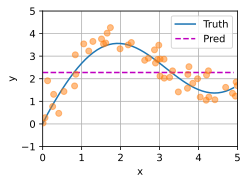

In [7]:
y_hat = tf.repeat(tf.reduce_mean(y_train), repeats=n_test)
plot_kernel_reg(y_hat)

## 2.3 非参数注意力汇聚

$$
f(x) = \sum_{i=1}^n \frac{K(x-x_i)}{\sum_{j=1}^n K(x-x_j)} y_i
$$

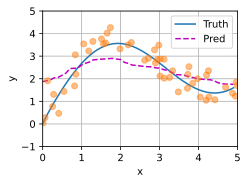

In [8]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_train, axis=0)
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = tf.nn.softmax(-(X_repeat - tf.expand_dims(x_train, axis=1))**2/2, axis=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = tf.matmul(attention_weights, tf.expand_dims(y_train, axis=1))
plot_kernel_reg(y_hat)

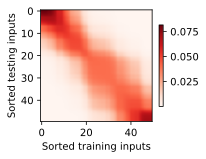

In [9]:
d2l.show_heatmaps(tf.expand_dims(
                      tf.expand_dims(attention_weights, axis=0), axis=0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 2.4 带参数注意力汇聚

# 3. 注意力评分函数

In [10]:
import tensorflow as tf
import d2l

## 3.1 masked_softmax

In [ ]:
def masked_softmax(X,valid_lens):
    '''通过在最后一个轴上遮蔽元素来执行softmax'''
    if valid_lens is None:
        return tf.nn.softmax(X,axis=-1)
    else:
        shape = X.shape
        if len(valid_lens.shape) == 1:
            valid_lens = tf.repeat(valid_lens,repeats=shape[1])
        else:
            valid_lens = tf.reshape(valid_lens,shape=-1)
        X = 